In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set random seed for reproducibility
np.random.seed(42)

# Configure display options
pd.set_option('display.max_columns', 100)

In [10]:
# Load datasets
fraud_data = pd.read_csv('../Data/raw/Fraud_Data.csv')
ip_country = pd.read_csv('../Data/raw/IpAddress_to_Country.csv')
credit_card = pd.read_csv('../Data/raw/creditcard.csv')

# Display dataset shapes
print("Fraud Data Shape:", fraud_data.shape)
print("IP Country Shape:", ip_country.shape)
print("Credit Card Shape:", credit_card.shape)

Fraud Data Shape: (151112, 11)
IP Country Shape: (138846, 3)
Credit Card Shape: (284807, 31)


In [11]:
# Check for missing values
print("\nMissing Values in Fraud Data:")
print(fraud_data.isnull().sum())

print("\nMissing Values in Credit Card Data:")
print(credit_card.isnull().sum())

# Impute missing values in fraud data
fraud_data.fillna({
    'age': fraud_data['age'].median(),
    'browser': 'Unknown',
    'source': 'Unknown'
}, inplace=True)


Missing Values in Fraud Data:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Missing Values in Credit Card Data:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [12]:
# Remove duplicate rows
fraud_data = fraud_data.drop_duplicates()
credit_card = credit_card.drop_duplicates()

print("\nFraud Data Shape after deduplication:", fraud_data.shape)
print("Credit Card Shape after deduplication:", credit_card.shape)


Fraud Data Shape after deduplication: (151112, 11)
Credit Card Shape after deduplication: (283726, 31)


In [13]:
# Convert timestamps to datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

# Convert categorical variables
categorical_cols = ['source', 'browser', 'sex', 'class']
fraud_data[categorical_cols] = fraud_data[categorical_cols].astype('category')

# Convert Class to int in credit card data
credit_card['Class'] = credit_card['Class'].astype(int)

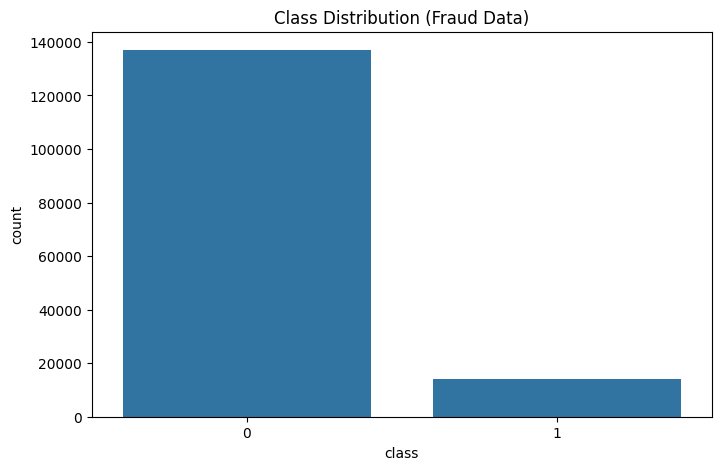

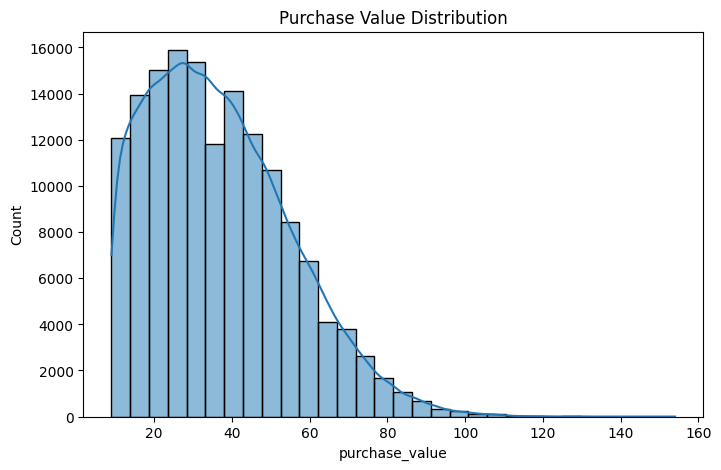

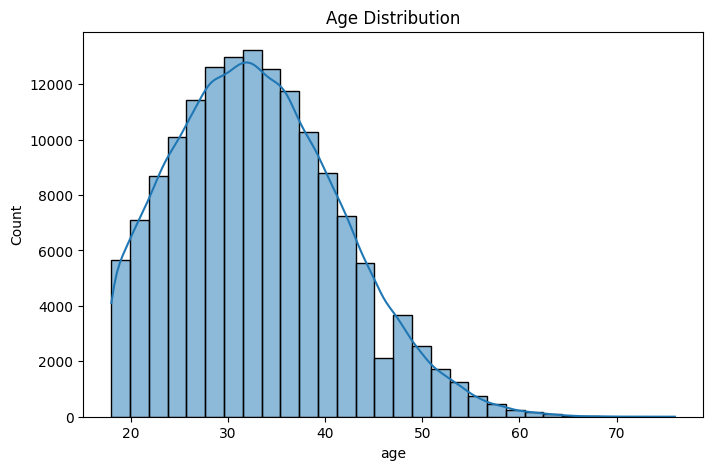

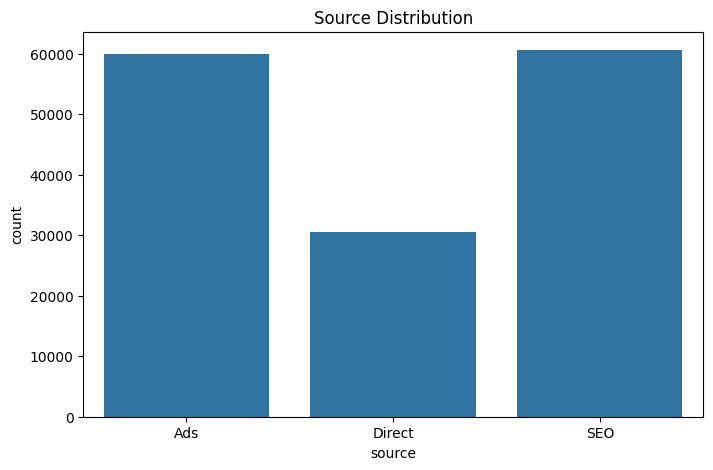

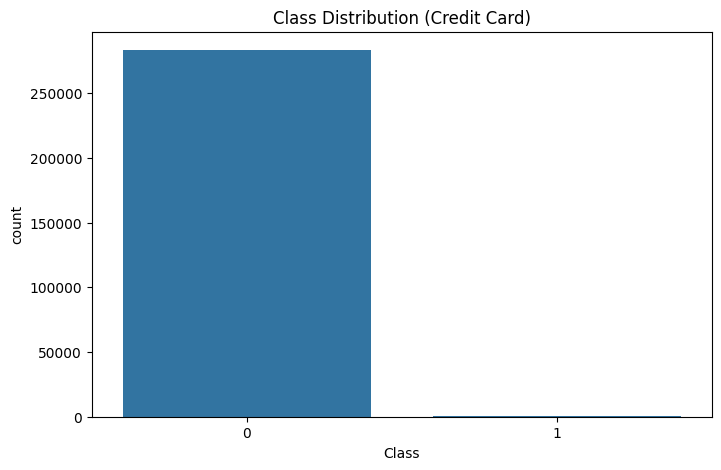

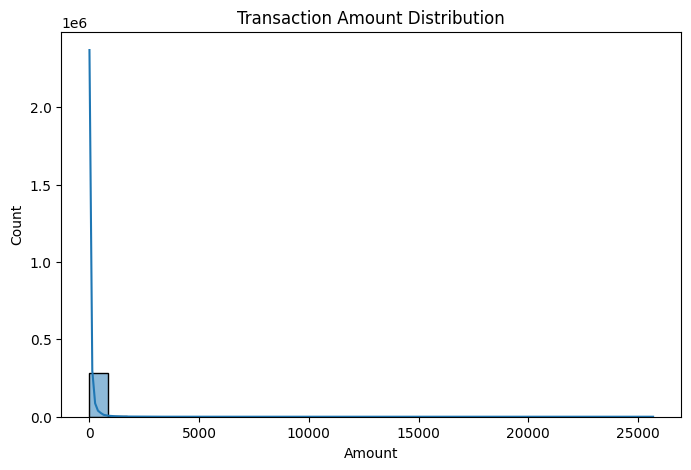

In [14]:
# Function to plot univariate analysis
def plot_univariate(data, col, title, figsize=(8, 5)):
    plt.figure(figsize=figsize)
    if data[col].dtype == 'category' or data[col].nunique() < 10:
        sns.countplot(x=col, data=data)
    else:
        sns.histplot(data[col], kde=True, bins=30)
    plt.title(title)
    plt.show()

# Fraud Data Analysis
plot_univariate(fraud_data, 'class', 'Class Distribution (Fraud Data)')
plot_univariate(fraud_data, 'purchase_value', 'Purchase Value Distribution')
plot_univariate(fraud_data, 'age', 'Age Distribution')
plot_univariate(fraud_data, 'source', 'Source Distribution')

# Credit Card Data Analysis
plot_univariate(credit_card, 'Class', 'Class Distribution (Credit Card)')
plot_univariate(credit_card, 'Amount', 'Transaction Amount Distribution')


Fraud Data Analysis:


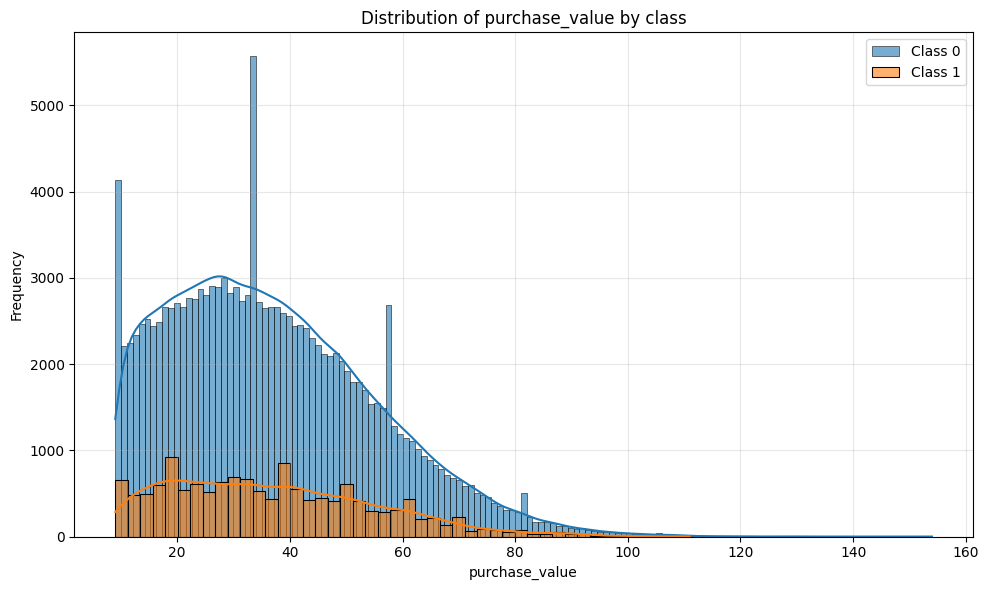

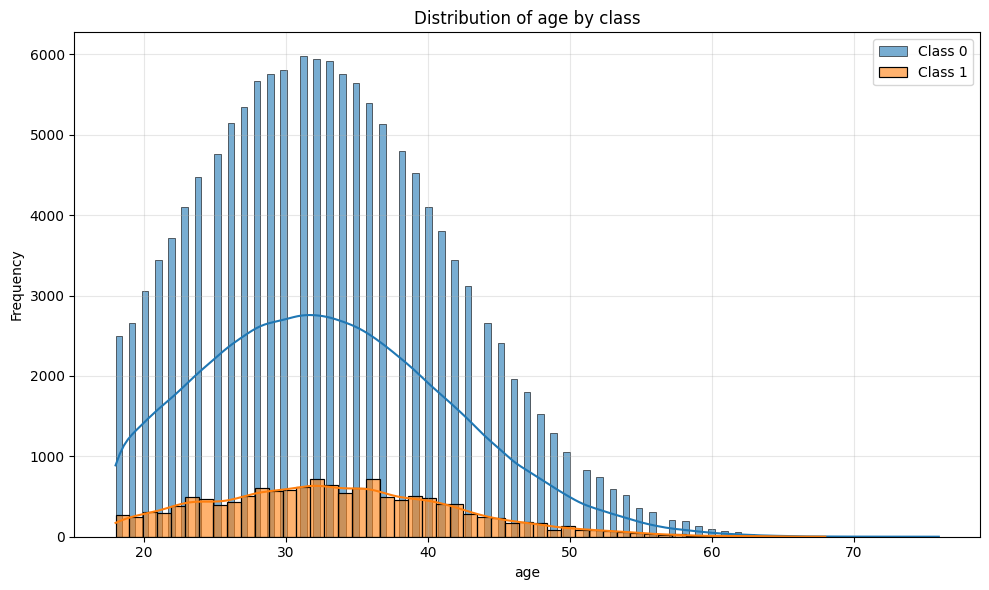


Credit Card Data Analysis:


C:\Users\hp\AppData\Local\Temp\ipykernel_10076\3257391695.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


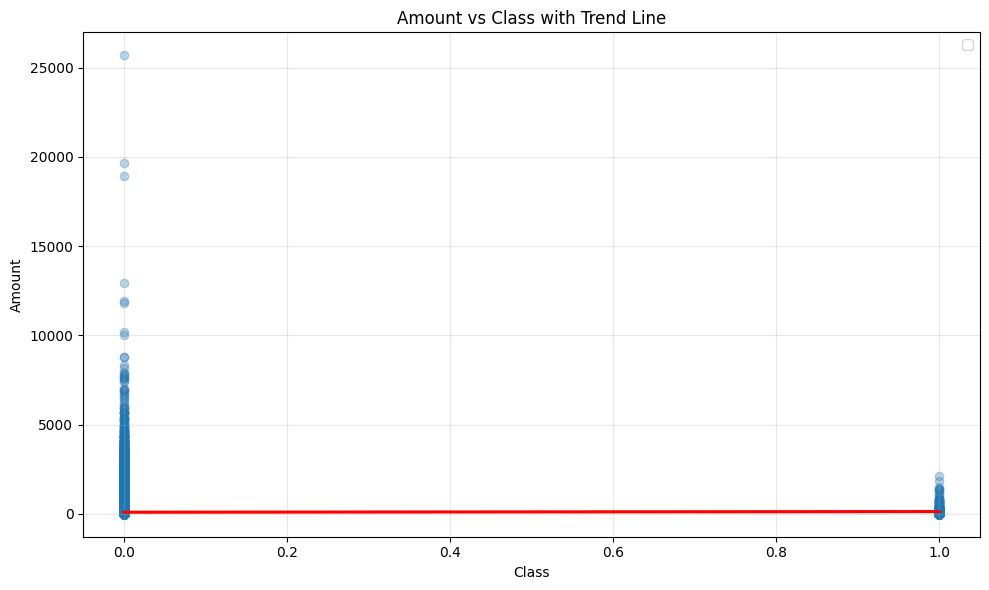

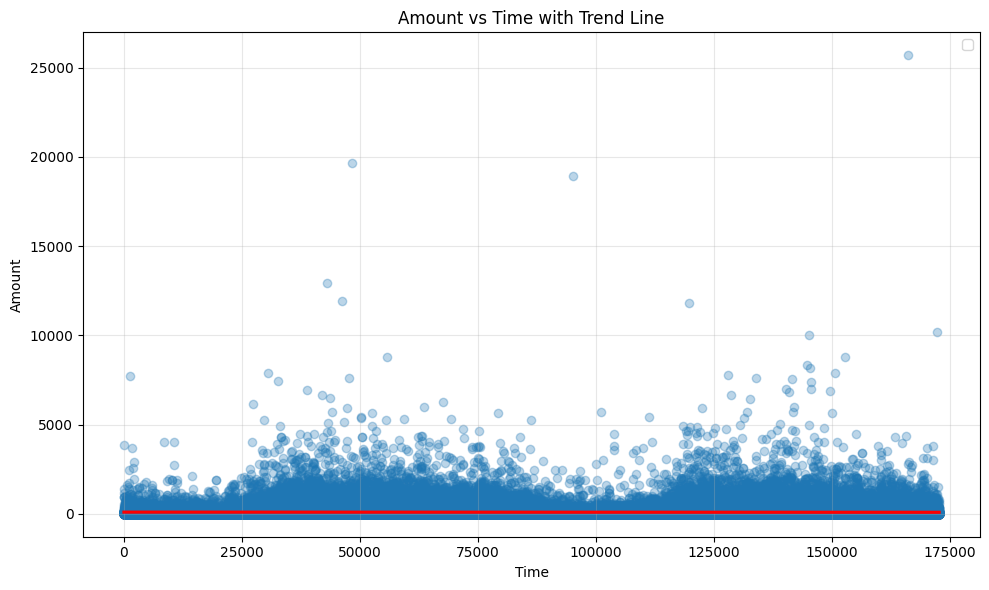

In [26]:
# Function for bivariate analysis with standard plots
def plot_bivariate_standard(data, x_col, y_col, title, figsize=(10, 6)):
    plt.figure(figsize=figsize)
    
    if data[x_col].dtype == 'category':
        # For categorical x-axis (class), use grouped bars/histograms
        for cls in data[x_col].cat.categories:
            subset = data[data[x_col] == cls]
            sns.histplot(subset[y_col], kde=True, label=f'Class {cls}', alpha=0.6)
        plt.title(f'Distribution of {y_col} by {x_col}')
        plt.xlabel(y_col)
        plt.ylabel('Frequency')
    else:
        # For numerical x-axis, use scatter plot with regression line
        sns.regplot(x=x_col, y=y_col, data=data, 
                   scatter_kws={'alpha':0.3}, 
                   line_kws={'color':'red'})
        plt.title(f'{y_col} vs {x_col} with Trend Line')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Fraud Data Analysis - Standard Plots
print("\nFraud Data Analysis:")
plot_bivariate_standard(fraud_data, 'class', 'purchase_value', 'Purchase Value Distribution by Class')
plot_bivariate_standard(fraud_data, 'class', 'age', 'Age Distribution by Class')

# Credit Card Data Analysis - Standard Plots
print("\nCredit Card Data Analysis:")
plot_bivariate_standard(credit_card, 'Class', 'Amount', 'Transaction Amount by Class')
plot_bivariate_standard(credit_card, 'Time', 'Amount', 'Transaction Amount Over Time')

In [17]:
# Since IP addresses are already in integer format, we can directly use them
# Rename columns for clarity
fraud_data = fraud_data.rename(columns={'ip_address': 'ip_int'})
ip_country = ip_country.rename(columns={
    'lower_bound_ip_address': 'lower_int',
    'upper_bound_ip_address': 'upper_int'
})

# Merge with country data
def find_country(ip_int):
    mask = (ip_country['lower_int'] <= ip_int) & (ip_int <= ip_country['upper_int'])
    country = ip_country.loc[mask, 'country']
    return country.values[0] if not country.empty else 'Unknown'

fraud_data['country'] = fraud_data['ip_int'].apply(find_country)

# Display country distribution
print("\nTop 10 Countries by Transaction Count:")
print(fraud_data['country'].value_counts().head(10))


Top 10 Countries by Transaction Count:
country
United States        58049
Unknown              21966
China                12038
Japan                 7306
United Kingdom        4490
Korea Republic of     4162
Germany               3646
France                3161
Canada                2975
Brazil                2961
Name: count, dtype: int64


In [18]:
# Time-based features
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.dayofweek
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600

# Transaction frequency features
fraud_data = fraud_data.sort_values(['user_id', 'purchase_time'])
fraud_data['time_since_last_trans'] = fraud_data.groupby('user_id')['purchase_time'].diff().dt.total_seconds() / 60
fraud_data['time_since_last_trans'].fillna(0, inplace=True)

# Transaction counts
fraud_data['user_trans_count'] = fraud_data.groupby('user_id')['user_id'].transform('count')
fraud_data['device_trans_count'] = fraud_data.groupby('device_id')['device_id'].transform('count')

# Display new features
print("\nSample of Engineered Features:")
print(fraud_data[['hour_of_day', 'day_of_week', 'time_since_signup', 
                 'time_since_last_trans', 'user_trans_count', 
                 'device_trans_count']].head())

C:\Users\hp\AppData\Local\Temp\ipykernel_10076\3483791247.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['time_since_last_trans'].fillna(0, inplace=True)



Sample of Engineered Features:
        hour_of_day  day_of_week  time_since_signup  time_since_last_trans  \
116708           10            5         990.273333                    0.0   
15108            21            5        2788.855278                    0.0   
46047            11            3        1852.000278                    0.0   
67650            23            2         103.136111                    0.0   
109067           20            2        1286.523611                    0.0   

        user_trans_count  device_trans_count  
116708                 1                   1  
15108                  1                   1  
46047                  1                   1  
67650                  1                   1  
109067                 1                   1  


In [20]:
# Prepare features and target for fraud data
X_fraud = fraud_data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 
                         'ip_int', 'ip_int', 'class'], axis=1)
y_fraud = fraud_data['class']

# One-hot encoding for categorical features
X_fraud = pd.get_dummies(X_fraud, columns=['source', 'browser', 'sex', 'country'])

# Split data before handling imbalance
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)

# Apply SMOTE to fraud data (oversampling minority class)
print("\nClass distribution before SMOTE:")
print(y_train_f.value_counts())

smote = SMOTE(random_state=42)
X_train_f, y_train_f = smote.fit_resample(X_train_f, y_train_f)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_f).value_counts())


Class distribution before SMOTE:
class
0    109568
1     11321
Name: count, dtype: int64

Class distribution after SMOTE:
class
0    109568
1    109568
Name: count, dtype: int64


In [21]:
# Identify numerical columns for scaling
num_cols = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 
           'day_of_week', 'user_trans_count', 'device_trans_count', 
           'time_since_last_trans']

# Initialize and fit scaler
scaler = StandardScaler()
X_train_f[num_cols] = scaler.fit_transform(X_train_f[num_cols])
X_test_f[num_cols] = scaler.transform(X_test_f[num_cols])

# Display scaled features
print("\nSample of Scaled Features:")
print(X_train_f[num_cols].head())


Sample of Scaled Features:
   purchase_value       age  time_since_signup  hour_of_day  day_of_week  \
0       -1.035183 -0.484291           1.120279    -0.807179    -1.013841   
1        0.947159 -0.365158           0.051540     1.570400     0.524669   
2       -0.594663  0.587898          -0.693684    -1.698771    -1.526678   
3       -0.539598  1.183559           1.084069     0.530209     1.550343   
4       -0.264272 -0.007762          -0.875707     1.570400     1.037506   

   user_trans_count  device_trans_count  time_since_last_trans  
0               0.0           -0.600278                    0.0  
1               0.0           -0.600278                    0.0  
2               0.0           -0.406379                    0.0  
3               0.0           -0.600278                    0.0  
4               0.0           -0.406379                    0.0  


In [22]:
# Prepare credit card data
X_cc = credit_card.drop('Class', axis=1)
y_cc = credit_card['Class']

# Split data
X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(
    X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc)

# Apply Random Undersampling (due to extreme imbalance)
print("\nCredit Card Class distribution before undersampling:")
print(y_train_cc.value_counts())

rus = RandomUnderSampler(random_state=42)
X_train_cc, y_train_cc = rus.fit_resample(X_train_cc, y_train_cc)

print("\nCredit Card Class distribution after undersampling:")
print(pd.Series(y_train_cc).value_counts())

# Scale numerical features
cc_num_cols = ['Time', 'Amount']
cc_scaler = StandardScaler()
X_train_cc[cc_num_cols] = cc_scaler.fit_transform(X_train_cc[cc_num_cols])
X_test_cc[cc_num_cols] = cc_scaler.transform(X_test_cc[cc_num_cols])


Credit Card Class distribution before undersampling:
Class
0    226602
1       378
Name: count, dtype: int64

Credit Card Class distribution after undersampling:
Class
0    378
1    378
Name: count, dtype: int64


In [27]:
import os
from joblib import dump

# Save fraud data
X_train_f.to_csv('../Data/processed/fraud_X_train.csv', index=False)
X_test_f.to_csv('../Data/processed/fraud_X_test.csv', index=False)
y_train_f.to_csv('../Data/processed/fraud_y_train.csv', index=False)
y_test_f.to_csv('../Data/processed/fraud_y_test.csv', index=False)
dump(scaler, '../Data/processed/fraud_scaler.joblib')

# Save credit card data
X_train_cc.to_csv('../Data/processed/creditcard_X_train.csv', index=False)
X_test_cc.to_csv('../Data/processed/creditcard_X_test.csv', index=False)
y_train_cc.to_csv('../Data/processed/creditcard_y_train.csv', index=False)
y_test_cc.to_csv('../Data/processed/creditcard_y_test.csv', index=False)
dump(cc_scaler, '../Data/processed/creditcard_scaler.joblib')

print("\nData preprocessing completed and saved successfully!")
print("Saved files:")
print(os.listdir('../Data/processed'))


Data preprocessing completed and saved successfully!
Saved files:
['creditcard_scaler.joblib', 'creditcard_X_test.csv', 'creditcard_X_train.csv', 'creditcard_y_test.csv', 'creditcard_y_train.csv', 'fraud_scaler.joblib', 'fraud_X_test.csv', 'fraud_X_train.csv', 'fraud_y_test.csv', 'fraud_y_train.csv']
